In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import holidays

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# = = = = = =
# own stuff

from data_prepro import get_energy_data_today

In [3]:
df_energy = get_energy_data_today(to_date="20231201")
print(df_energy.info())
df_energy.tail(5)

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78168 entries, 2014-12-31 23:00:00+00:00 to 2023-12-01 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78168 non-null  datetime64[ns, CET]
 1   gesamt         78168 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75


In [7]:
def create_dummy_df(df, hour_method='simple'):

    df_energy_dummy = df.copy()

    # binary dummy var for each month
    dummy_month = pd.get_dummies(df_energy['timestamp_CET'].dt.month, prefix='month').astype(int)
    # leave out first month to avoid multicollinearity
    dummy_month = dummy_month.iloc[:, 1:]

    # binary dummy var for each weekday
    dummy_weekday = pd.get_dummies(df_energy['timestamp_CET'].dt.weekday, prefix='weekday').astype(int)
    # leave out first weekday to avoid multicollinearity
    dummy_weekday = dummy_weekday.iloc[:, 1:]

    # - - - - - - - - -
    # concat dummies
    df_energy_dummy = pd.concat([df_energy_dummy, dummy_month], axis=1)
    df_energy_dummy = pd.concat([df_energy_dummy, dummy_weekday], axis=1)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # create hour dummies

    if hour_method == 'simple':

        # binary dummy var for each hour
        dummy_hour = pd.get_dummies(df_energy['timestamp_CET'].dt.hour, prefix='hour').astype(int)
        # leave out first hour to avoid multicollinearity
        dummy_hour = dummy_hour.iloc[:, 1:]
        df_energy_dummy = pd.concat([df_energy_dummy, dummy_hour], axis=1)

    if hour_method == 'seasonal':

        # separate hourly dummy vars for summer and winter months
        summer_months = [4, 5, 6, 7, 8, 9]
        df_energy_dummy['is_summer'] = df_energy['timestamp_CET'].dt.month.isin(summer_months).astype(int)

        # create dummy variables for each hour in summer months
        for hr in range(1, 24):
            # skip hour 0 in summer to avoid multicollinearity
            df_energy_dummy[f'hour_{hr}_summer'] = ((df_energy_dummy['is_summer'] == 1) & (df_energy_dummy['timestamp_CET'].dt.hour == hr)).astype(int)

        for hr in range(1, 24):
            # skip hour 0 in winter to avoid multicollinearity
            df_energy_dummy[f'hour_{hr}_winter'] = ((df_energy_dummy['is_summer'] == 0) & (df_energy_dummy['timestamp_CET'].dt.hour == hr)).astype(int)

        # drop is_summer
        df_energy_dummy.drop(columns=['is_summer'], inplace=True)

    if hour_method == 'monthly':

        # separate hourly dummy vars for EVERY month
        month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
                    6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',
                    11: 'November', 12: 'December'}

        for m_idx in range(1, 13):
            
            m_name = month_dict[m_idx][:3].lower() # short version of month name

            for hr in range(1, 24):
                # skip hour 0 to avoid multicollinearity
                df_energy_dummy[f'hour_{hr}_{m_name}'] = ((df_energy_dummy['timestamp_CET'].dt.month == m_idx) & 
                                                        (df_energy_dummy['timestamp_CET'].dt.hour == hr)).astype(int)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # create holiday dummies

    # get all years in dataframe
    uniq_yrs = df_energy['timestamp_CET'].dt.year.unique()

    # get holidays for germany for all states and combine them into one single dict
    states = ['BB', 'BE', 'BW', 'BY', 'BYP', 'HB', 'HE', 'HH', 'MV', 
              'NI', 'NW', 'RP', 'SH', 'SL', 'SN', 'ST', 'TH']
    
    holidays_de = holidays.CountryHoliday('DE', years=uniq_yrs)
    for state in states:
        holidays_de.update(holidays.CountryHoliday('DE', state=state, years=uniq_yrs))

    # sort holidays
    holidays_de = dict(sorted(holidays_de.items()))

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    # newyears + silvester ist kein feiertag aber die meisten nehmen trotzdem frei
    # create dummy variable for all rows where timestamp_CET is 12.31 or 01.01
    df_energy_dummy['is_holiday_newyear_d31'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 31))
    df_energy_dummy['is_holiday_newyear_d01'] = ((df_energy_dummy['timestamp_CET'].dt.month == 1) & (df_energy_dummy['timestamp_CET'].dt.day == 1))

    # Heilige Drei Könige (01.06)
    threekings_dates = [k for k, v in holidays_de.items() if v == 'Heilige Drei Könige']
    df_energy_dummy['is_holiday_threekings'] = df_energy_dummy['timestamp_CET'].dt.date.isin(threekings_dates)

    # Karfreitag (easter - 2d)
    karfreitag_dates = [k for k, v in holidays_de.items() if v == 'Karfreitag']
    df_energy_dummy['is_holiday_karfreitag'] = df_energy_dummy['timestamp_CET'].dt.date.isin(karfreitag_dates)

    # Eastermonday (easter + 1d)
    easter_dates = [k for k, v in holidays_de.items() if v == 'Ostermontag']
    df_energy_dummy['is_holiday_easter'] = df_energy_dummy['timestamp_CET'].dt.date.isin(easter_dates)

    # Erster Mai / Tag der Arbeit (05.01)
    erstermai_dates = [k for k, v in holidays_de.items() if v == 'Erster Mai']
    df_energy_dummy['is_holiday_erstermai'] = df_energy_dummy['timestamp_CET'].dt.date.isin(erstermai_dates)

    # Christi Himmelfahrt (easter + 39d)
    himmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Christi Himmelfahrt']
    df_energy_dummy['is_holiday_himmelfahrt'] = df_energy_dummy['timestamp_CET'].dt.date.isin(himmelfahrt_dates)

    # Pfingstmontag (easter + 50d)
    pfingstmontag_dates = [k for k, v in holidays_de.items() if v == 'Pfingstmontag']
    df_energy_dummy['is_holiday_pfingstmontag'] = df_energy_dummy['timestamp_CET'].dt.date.isin(pfingstmontag_dates)

    # Fronleichnam (easter + 60d)
    fronleichnam_dates = [k for k, v in holidays_de.items() if v == 'Fronleichnam']
    df_energy_dummy['is_holiday_fronleichnam'] = df_energy_dummy['timestamp_CET'].dt.date.isin(fronleichnam_dates)

    # Maria Himmelfahrt (08.15)
    mariahimmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Mariä Himmelfahrt']
    df_energy_dummy['is_holiday_mariahimmelfahrt'] = df_energy_dummy['timestamp_CET'].dt.date.isin(mariahimmelfahrt_dates)

    # Tag der Deutschen Einheit (10.03)
    einheit_dates = [k for k, v in holidays_de.items() if v == 'Tag der Deutschen Einheit']
    df_energy_dummy['is_holiday_einheit'] = df_energy_dummy['timestamp_CET'].dt.date.isin(einheit_dates)

    # Reformationstag (10.31)
    reformationstag_dates = [k for k, v in holidays_de.items() if v == 'Reformationstag']
    df_energy_dummy['is_holiday_reformationstag'] = df_energy_dummy['timestamp_CET'].dt.date.isin(reformationstag_dates)

    # Allerheiligen (11.01)
    allerheiligen_dates = [k for k, v in holidays_de.items() if v == 'Allerheiligen']
    df_energy_dummy['is_holiday_allerheiligen'] = df_energy_dummy['timestamp_CET'].dt.date.isin(allerheiligen_dates)

    # christmas = list of datetimes from 12.24 to 12.26 
    df_energy_dummy['is_holiday_xmas_d23'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 23))
    df_energy_dummy['is_holiday_xmas_d24'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 24))
    df_energy_dummy['is_holiday_xmas_d25'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 25))
    df_energy_dummy['is_holiday_xmas_d26'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 26))

    # brückentage zwischen weihnachten und neujahr
    # 12.27, 12.28, 12.29, 12.30
    df_energy_dummy['is_holiday_xmas2newyear'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day.isin([27,28,29,30])))

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # reformat all columns that begin with "is_holiday" to int
    for col in df_energy_dummy.columns:
        if col.startswith('is_holiday'):
            df_energy_dummy[col] = df_energy_dummy[col].astype(int)

    return df_energy_dummy

In [19]:
def fit_lin_reg(df, method='ols', test_perc=0.01, drop_cols=None, title_addon=None):

    if drop_cols is None:
        drop_cols = ['timestamp_CET']
    else:
        drop_cols.append('timestamp_CET')

    # drop columns
    df = df.drop(drop_cols, axis=1)

    # do train test split manually
    n_total = df.shape[0]
    n_train = int((1-test_perc) * n_total)
    n_test = n_total - n_train

    X_train = df.iloc[:n_train]
    X_test = df.iloc[-n_test:]

    y_train = X_train['gesamt']
    y_test = X_test['gesamt']

    X_train = X_train.drop(['gesamt'], axis=1)
    X_test = X_test.drop(['gesamt'], axis=1)

    # Add a constant term to the features matrix for statsmodels
    X_train = sm.add_constant(X_train)
    # Create model using OLS (Ordinary Least Squares)
    model = sm.OLS(y_train, X_train)

    if method == 'ols' :

        results = model.fit()
        print(results.summary())

        r_sqrd = results.rsquared
        r_sqrd_adj = results.rsquared_adj

    elif method == 'ridge' :

        results = model.fit_regularized(method = 'elastic_net')
        print(results.params.to_string())
        # [TODO] how to get r squared ???

    # Add a constant term to the features matrix for the test set
    X_test = sm.add_constant(X_test, has_constant='add')

    # PROBLEM eg if first column is "is_summer" and the test set is in summer, then the first column is already constant = 1 everywhere
    # BUT we still want to add a constant row to make sure the model works / has the right dimension
    # SO we set has_constant = 'add' to force the constant row to be added

    # Make predictions
    y_pred = results.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")

    title = f"Lin Reg using {method} and {len(X_train.columns)} predictors"
    
    if method == 'ols' :
        title = f"{title}, r2={r_sqrd:.4f}, r2_adj={r_sqrd_adj:.4f}"
    # if method == 'ridge' :
    #     title = ...
    
    title = f"{title}, {title_addon}"

    # Plot out of sample predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_test, label='test')
    plt.plot(y_test.index, y_pred, label=f'predicted, rmse = {rmse:.2f}')
    
    plt.title(title)
    plt.legend()
    plt.show()

    return X_train, X_test, y_train, y_test, results, y_pred


                            OLS Regression Results                            
Dep. Variable:                 gesamt   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     4201.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:59:03   Log-Likelihood:            -2.7966e+05
No. Observations:               29328   AIC:                         5.594e+05
Df Residuals:                   29269   BIC:                         5.599e+05
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

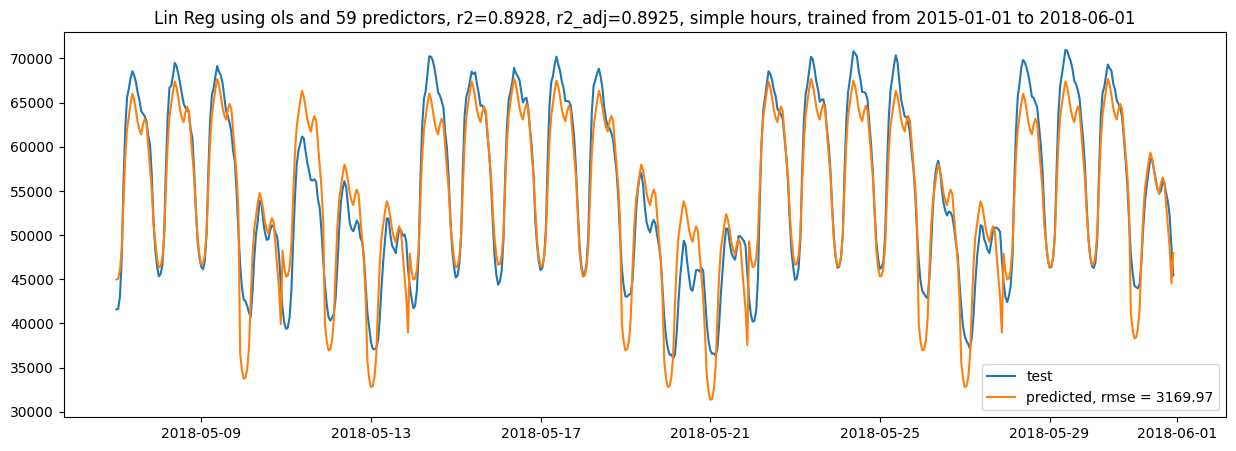

const                          54908.685557
month_2                          166.362611
month_3                        -2320.399452
month_4                        -5956.093260
month_5                        -7343.354572
month_6                        -7591.441990
month_7                        -7438.594500
month_8                        -8606.505102
month_9                        -7183.894271
month_10                       -4721.646716
month_11                       -1286.910907
month_12                        -220.367644
weekday_1                       1449.386709
weekday_2                       1736.511245
weekday_3                       1548.124762
weekday_4                        382.671535
weekday_5                      -7952.819527
weekday_6                     -12112.955144
hour_1                         -1658.106151
hour_2                         -2642.558083
hour_3                         -2537.262268
hour_4                         -1557.587145
hour_5                          

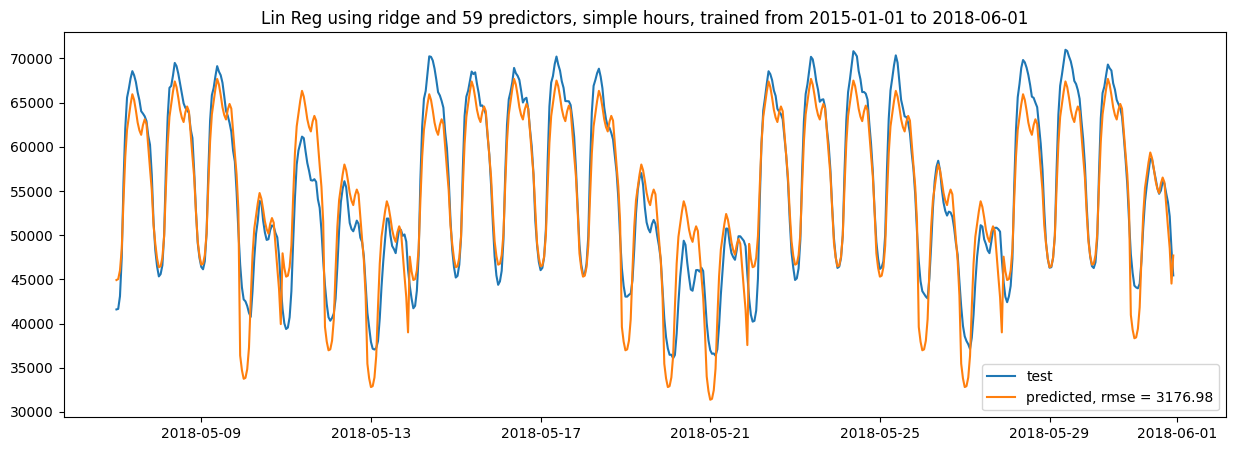

                            OLS Regression Results                            
Dep. Variable:                 gesamt   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     3158.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:59:13   Log-Likelihood:            -2.7901e+05
No. Observations:               29328   AIC:                         5.582e+05
Df Residuals:                   29246   BIC:                         5.589e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

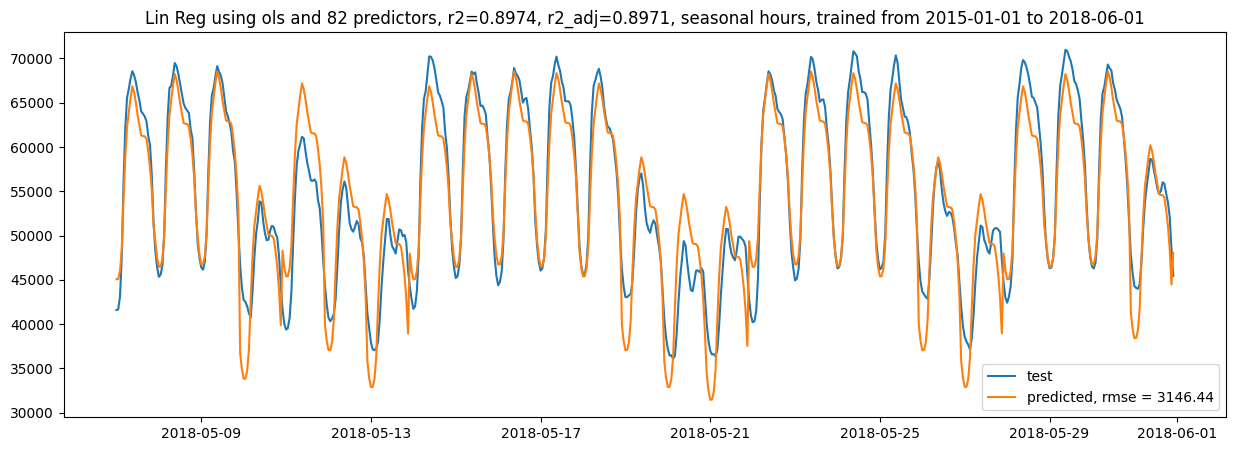

const                          54081.182770
month_2                          321.567238
month_3                        -2166.266033
month_4                        -4186.631809
month_5                        -5571.074111
month_6                        -5820.396663
month_7                        -5668.726042
month_8                        -6834.942195
month_9                        -5414.603236
month_10                       -4566.920515
month_11                       -1131.509182
month_12                         -62.917127
weekday_1                       1541.298331
weekday_2                       1827.605687
weekday_3                       1640.665222
weekday_4                        474.458746
weekday_5                      -7860.951359
weekday_6                     -12021.064895
hour_1_summer                  -2547.086364
hour_2_summer                  -3573.855984
hour_3_summer                  -3552.173078
hour_4_summer                  -2660.966667
hour_5_summer                   

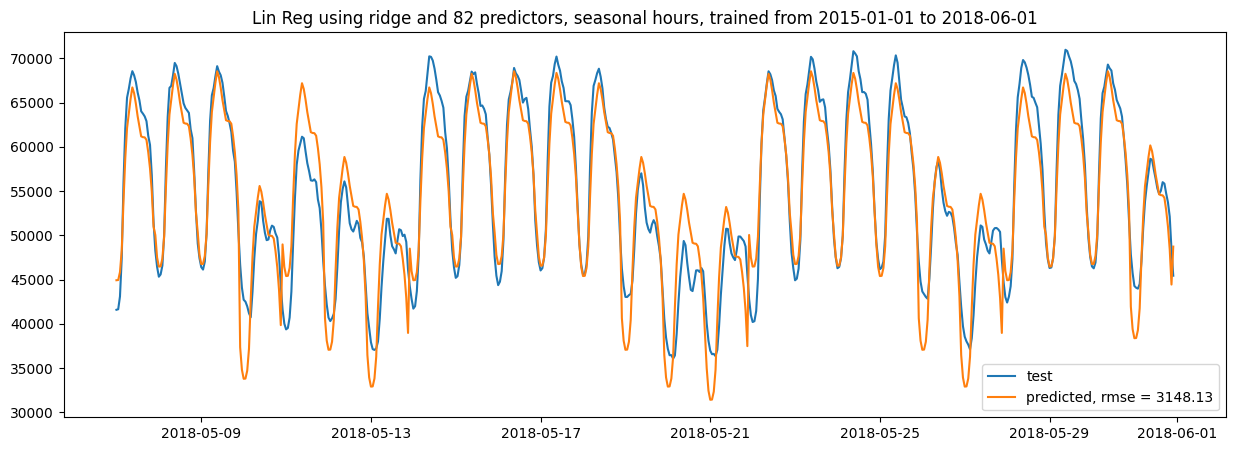

                            OLS Regression Results                            
Dep. Variable:                 gesamt   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     853.5
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:59:39   Log-Likelihood:            -2.7842e+05
No. Observations:               29328   AIC:                         5.575e+05
Df Residuals:                   29016   BIC:                         5.600e+05
Df Model:                         311                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

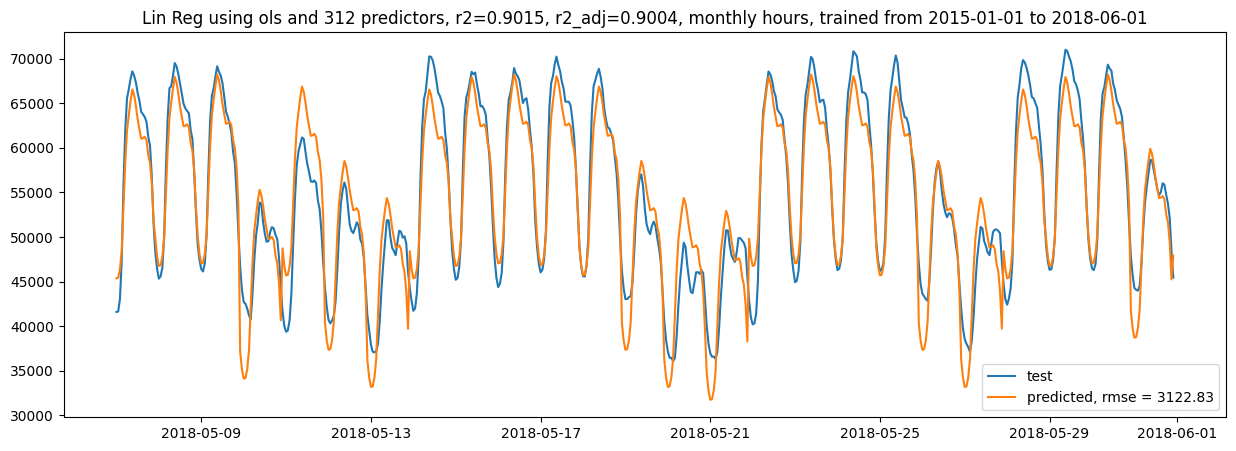

const                          52571.594604
month_2                         3847.507314
month_3                         1373.210422
month_4                        -2223.486222
month_5                        -3557.692422
month_6                        -4247.017206
month_7                        -3904.360830
month_8                        -5280.039106
month_9                        -4496.664081
month_10                       -1934.150574
month_11                         800.003341
month_12                        3445.727053
weekday_1                       1495.740192
weekday_2                       1781.737665
weekday_3                       1594.119790
weekday_4                        428.971712
weekday_5                      -7906.407941
weekday_6                     -12066.309070
hour_1_jan                       822.465371
hour_2_jan                      -223.462048
hour_3_jan                      -221.224145
hour_4_jan                       600.271823
hour_5_jan                      

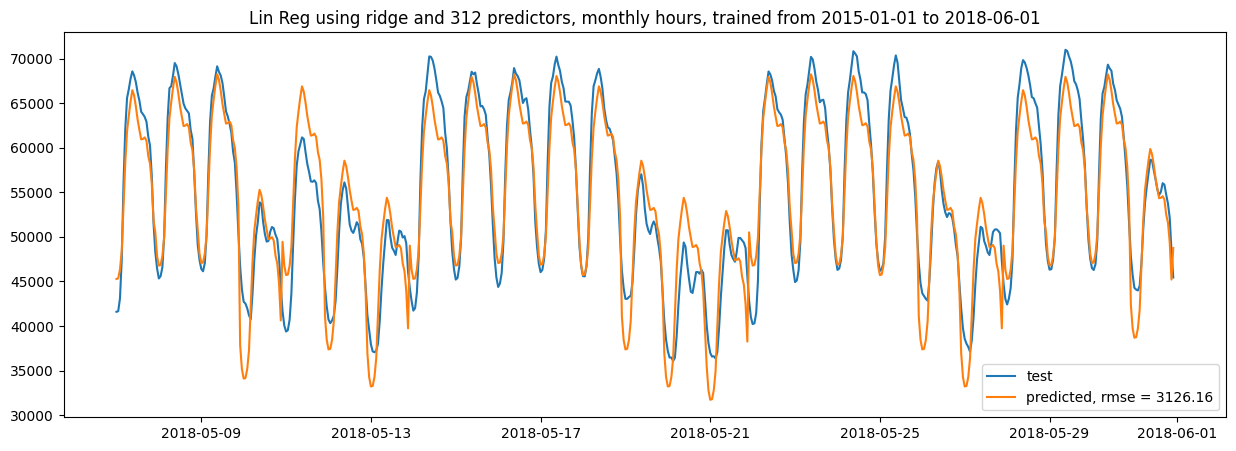

In [20]:
for hour_method in ['simple', 'seasonal', 'monthly']: 

    df_energy_dummy = create_dummy_df(df_energy, hour_method=hour_method)

    # take smaller dataset
    start = '2015-01-01'
    end = '2018-06-01'
    df_energy_dummy_small = df_energy_dummy.loc[(df_energy_dummy['timestamp_CET'] > start) & 
                                                (df_energy_dummy['timestamp_CET'] <= end)]
                                                
    # fit model on all data and another fit without "is_weekend" and "is_night"
    title_add = f'{hour_method} hours, trained from {start} to {end}'
    res = fit_lin_reg(df_energy_dummy_small, test_perc=0.02, method='ols', title_addon=title_add)
    res = fit_lin_reg(df_energy_dummy_small, test_perc=0.02, method='ridge', title_addon=title_add)


In [27]:
# create matrix with random numbers
test_x = np.random.rand(10, 2)
print(test_x)

print('- '*10)
recursive_x = test_x[0, :]
print(f"first recursive input: {recursive_x}")

forecast_ms = []
for i in range(test_x.shape[0]):
    print(f"model input = {recursive_x.reshape((1, recursive_x.shape[0]))}")
    # pred = model.predict(recursive_x.reshape((1, recursive_x.shape[0])))
    pred = 10
    recursive_x = np.append(recursive_x[1:], pred)
    print(f"new recursive input: {recursive_x}")
    forecast_ms.append(pred)

[[0.20843762 0.03689055]
 [0.73711034 0.04794852]
 [0.18636514 0.89091777]
 [0.79122139 0.27584544]
 [0.8793846  0.27557767]
 [0.4707903  0.45994948]
 [0.62271271 0.01698398]
 [0.53944659 0.37332628]
 [0.24191872 0.31313416]
 [0.43841856 0.00327152]]
- - - - - - - - - - 
first recursive input: [0.20843762 0.03689055]
model input = [[0.20843762 0.03689055]]
new recursive input: [ 0.03689055 10.        ]
model input = [[ 0.03689055 10.        ]]
new recursive input: [10. 10.]
model input = [[10. 10.]]
new recursive input: [10. 10.]
model input = [[10. 10.]]
new recursive input: [10. 10.]
model input = [[10. 10.]]
new recursive input: [10. 10.]
model input = [[10. 10.]]
new recursive input: [10. 10.]
model input = [[10. 10.]]
new recursive input: [10. 10.]
model input = [[10. 10.]]
new recursive input: [10. 10.]
model input = [[10. 10.]]
new recursive input: [10. 10.]
model input = [[10. 10.]]
new recursive input: [10. 10.]
